In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import trange, tqdm

DEVICE = 'cuda'

torch.__version__, torch.cuda.is_available()

('1.3.1', True)

In [2]:
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.permute(1, 2, 0))
    ]),
    download=True
)

mk_data_loader = lambda bs: torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=bs,
    shuffle=True
)

dl = mk_data_loader(12)
X, y = next(iter(dl))
X.shape

Files already downloaded and verified


torch.Size([12, 32, 32, 3])

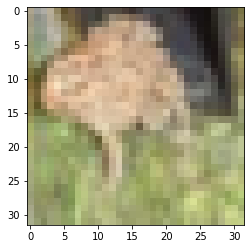

In [3]:
plt.imshow(X[0])

In [4]:
def conv_layers(type, input_channels, config):
    block_type = nn.Conv2d if type == 'conv' else nn.ConvTranspose2d

    def block(in_k, out_k, ks, stride):
        return [
            block_type(in_k, out_k, ks, stride),
            nn.BatchNorm2d(out_k),
            nn.ReLU()
        ]

    return [
        el for in_k, rest
        in zip([input_channels] + [c[0] for c in config], config) for el
        in block(in_k, *rest)
    ]

class Lambda(nn.Module):
    def __init__(self, handler):
        super(Lambda, self).__init__()
        self.handler = handler
        
    def forward(self, *args):
        return self.handler(*args)

In [5]:
torch.rand(12, 11 * 11).reshape(-1, 1, 11, 11).shape

torch.Size([12, 1, 11, 11])

In [6]:
class VAE(nn.Module):
    def __init__(self, input_shape, encoding_size):
        super(VAE, self).__init__()
        self.input_shape = input_shape

        self.encode = nn.Sequential(*[
            Lambda(lambda x: x.permute(0, 3, 1, 2)),
            *conv_layers('conv', 3, [
                (32 , 4, 2),
                (64 , 4, 2),
                (128, 4, 2),
            ]),
            nn.Flatten(),
            nn.Linear(512, encoding_size * 2),
            Lambda(lambda x: torch.chunk(x, 2, dim=1))
        ])
        
        self.decode = nn.Sequential(*[
            nn.Linear(encoding_size, 512),
            Lambda(lambda x: x.reshape(-1, 128, 2, 2)),
            *conv_layers('deconv', 128, [
                (64, 4, 3),
                (32, 4, 2),
            ]),
            nn.ConvTranspose2d(32, 3, (2, 2), 2),
            nn.Sigmoid(),
            Lambda(lambda x: x.permute(0, 2, 3, 1)),
        ])
        
        self.loss = nn.BCELoss(reduction='none')
        
    def criterion(self, x):
        mu, log_sig = vae.encode(x)
        s = vae.sample(mu, log_sig)
        y = vae.decode(s)

        recon = self.loss(y, x)
        recon = torch.sum(recon.reshape(recon.size(0), -1), dim=1)
        kl = 0.5 * torch.sum(torch.exp(log_sig) + mu ** 2.0 - 1.0 - log_sig, dim=1)
        
        return (recon + kl).mean()
    
    def sample(self, mu, log_sig):
        s = torch.normal(0, 1, mu.shape).to(DEVICE)
        return mu + s * torch.exp(log_sig / 2)
    
    def forward(self, x):
        mu, log_sig = vae.encode(x)
        s = vae.sample(mu, log_sig)
        out = vae.decode(s)
        return out

In [7]:
latent_size = 256
vae = VAE(X[0].shape, latent_size).to(DEVICE)
inp = torch.rand(X.shape).to(DEVICE)
out = vae.criterion(inp)
out

tensor(2315.7607, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
def optimize(model, data, epochs, lr=0.01):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    tr = trange(epochs)
    torch.cuda.empty_cache()

    for epoch in tr:
        data_iterator = tqdm(
            enumerate(data),
            total=len(data),
            desc='Epoch [%i/%i]' % (epoch + 1, epochs)
        )

        for i, (X, y) in data_iterator:
            X = X.to(DEVICE)
            optimizer.zero_grad()
            loss = model.criterion(X)

            loss.backward()
            optimizer.step()

            l = loss.item()
            tr.set_description('Loss %.6f' % l)
            data_iterator.set_description('Epoch [%i/%i] (L:%.3f)' % (epoch + 1, epochs, l))
            tr.refresh() 

        fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))
        X_rec = vae(X.to(DEVICE))

        axs[0].imshow(X[0].cpu().numpy())
        axs[1].imshow(X_rec[0].cpu().detach().numpy())
        plt.show()

        history.append(l)
    
    return history

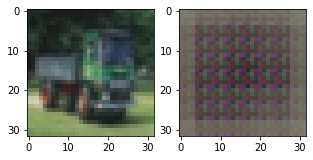

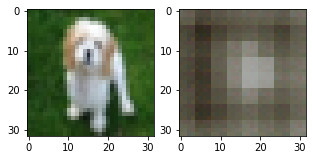

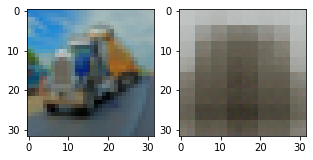

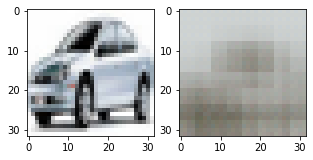

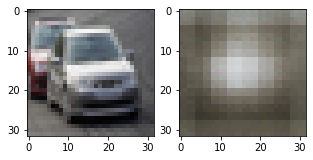

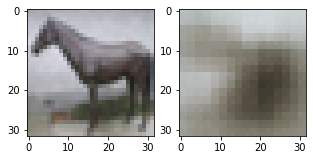

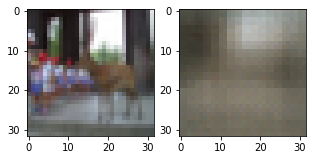

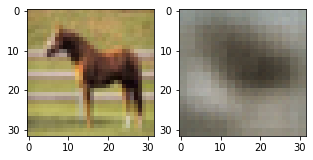

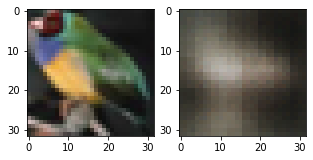

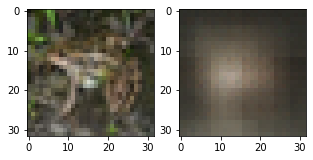

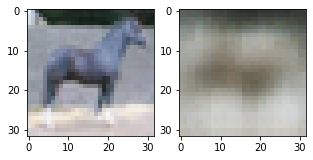

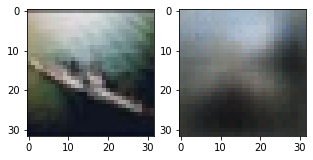

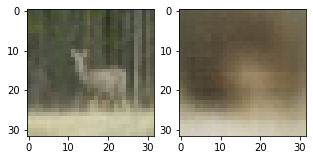

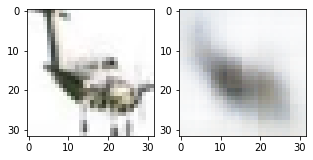

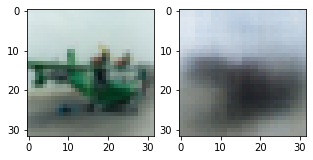

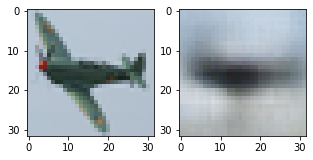

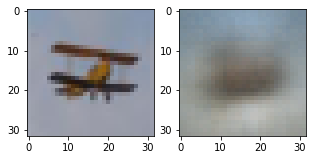

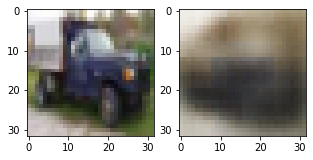

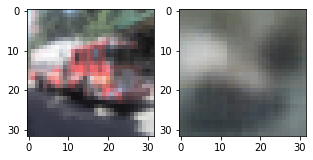

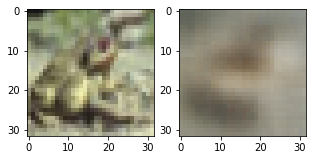

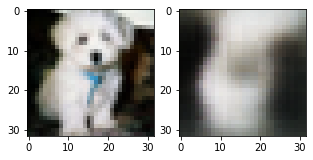

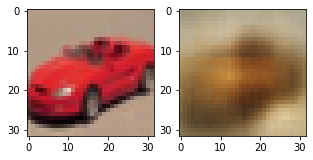

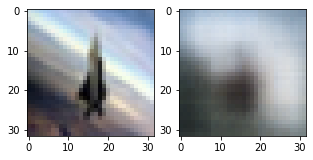

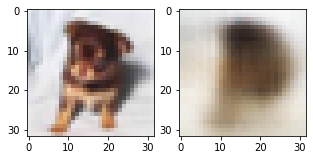

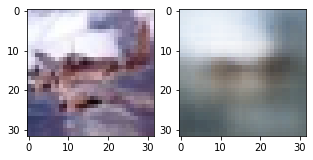

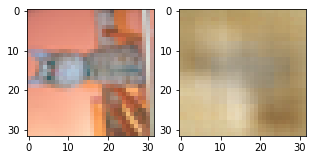

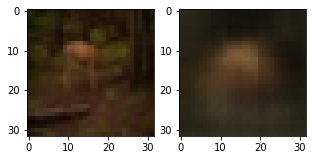

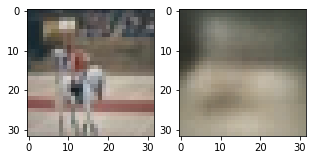

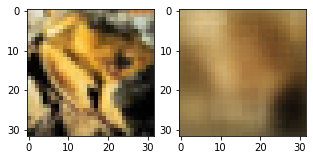

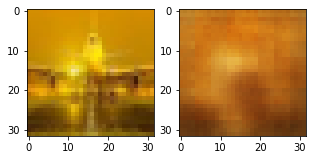

In [9]:
loader = mk_data_loader(bs=2048)
history = optimize(
    model=vae,
    data=loader,
    epochs=30,
    lr=0.01
)

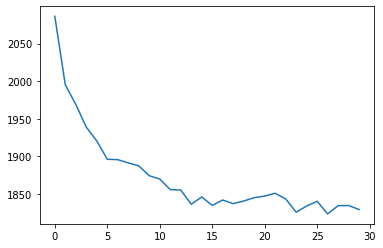

In [10]:
plt.plot(history)

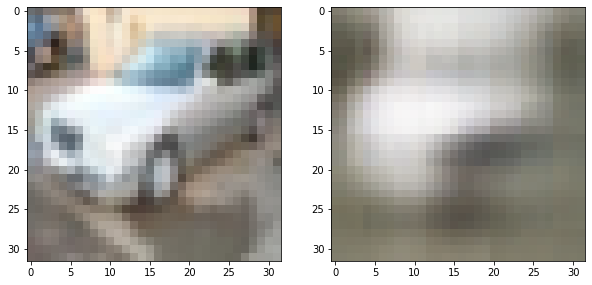

In [11]:
X = next(iter(loader))[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
X_rec = vae(X.to(DEVICE))

axs[0].imshow(X[0])
axs[1].imshow(X_rec[0].cpu().detach().numpy())

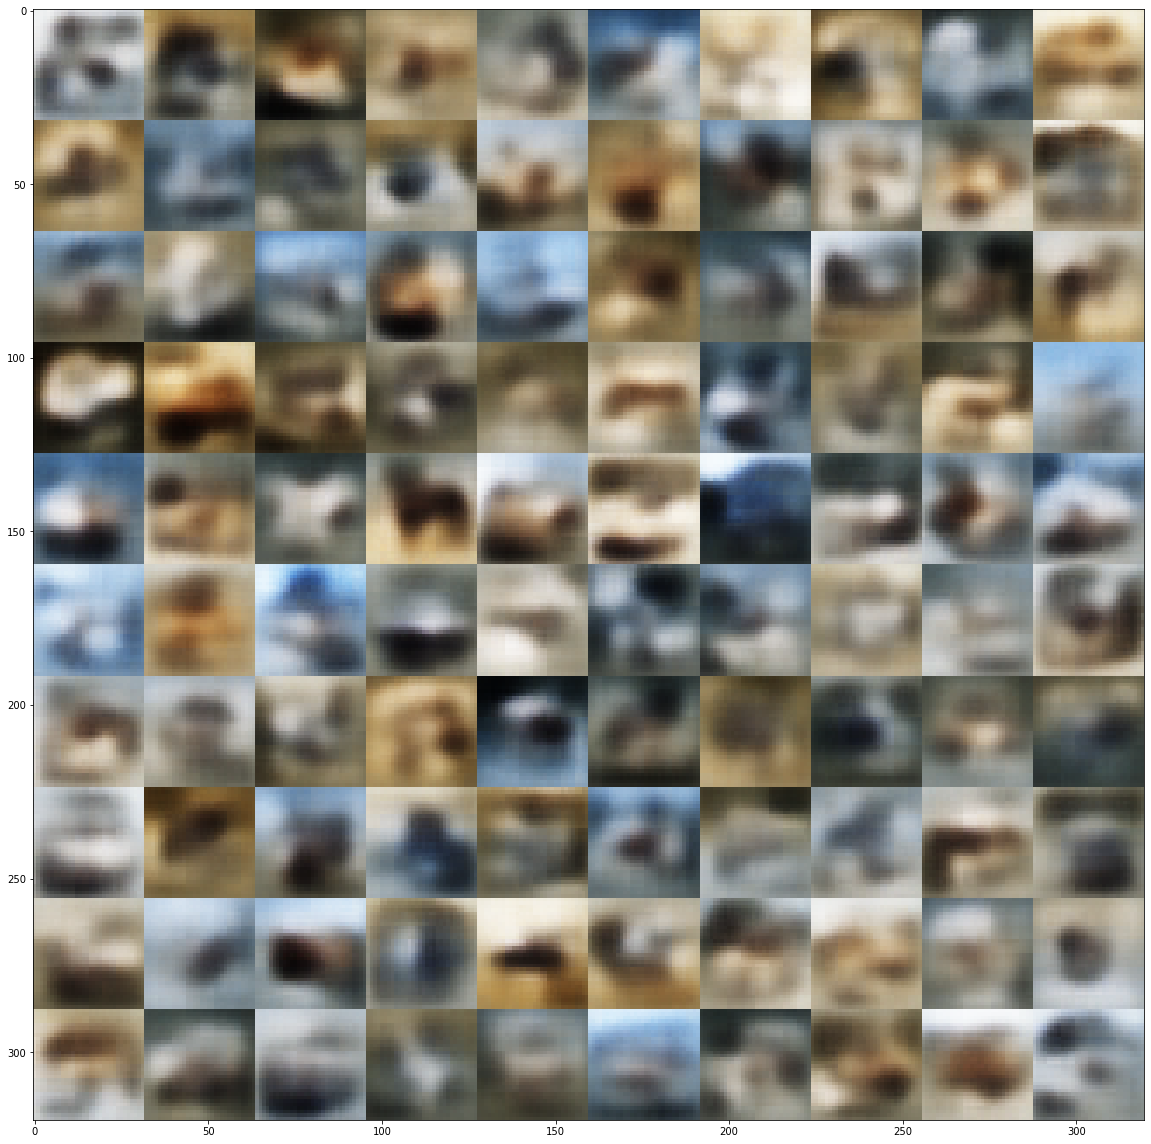

In [12]:
cols, rows = 10, 10

vae.eval()
seeds = torch.normal(0, 1, (rows * cols, latent_size)).to(DEVICE)
imgs = vae.decode(seeds).detach().cpu().numpy()
imgs = imgs.reshape(rows, cols, *imgs.shape[1:])

imgs = np.split(imgs, rows)
imgs = np.concatenate(imgs, axis=2)[0]
imgs = np.split(imgs, cols)
imgs = np.concatenate(imgs, axis=2)[0]

fix, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(imgs)
plt.tight_layout()